In this code, we try variational autoencoder on MNIST Dataset.

In [1]:
# IMPORT NECESSARY PACKAGES

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from PIL import Image

# for random splitting
from sklearn.model_selection import train_test_split

# import Keras classes
import keras
from keras.models import Model
from keras import layers
from keras.layers.core import Dense, Dropout, Activation
import keras.optimizers as koptim
from keras.utils import np_utils
from keras import regularizers
from keras import backend as K   # 'generic' backend so code works with either tensorflow or theano

# CHECK GPU
print(K.tensorflow_backend._get_available_gpus())


Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']


Define Hyperparameters

In [4]:
np.random.seed(237)

# network and training hyperpameters
EPOCHS = 7
BATCH_SIZE = 16
VERBOSE = 1
CLASSES = 10  # number of outputs = number of digits
HIDDEN_NODES = 128
VALIDATION_SPLIT=0.2  # how much TRAIN is reserved for VALIDATION
DROPOUT = 0.3  # drop 30% of the nodes for dropout
LEARN_RATE = 0.0001
LAMBDA = 0
INPUT_SHAPE = (128, 128, 3)
LATENT_DIM = 32

# select optimizer type
# GD: gradient descent
# SGD: Stocastic Gradient Descent
# RMS: RMSProp optimizer
# ADAM: Adam optimizer
OPTIMIZER_TYPE = "ADAM"
if(OPTIMIZER_TYPE == "SGD"):
    OPTIMIZER = koptim.SGD()
elif(OPTIMIZER_TYPE == "RMS"):
    # keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
    OPTIMIZER = koptim.RMSprop()
elif(OPTIMIZER_TYPE == "ADAM"):
    # Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    OPTIMIZER = koptim.Adam(lr = LEARN_RATE)

Load MNIST Dataset. Keras provides support for MNIST dataset.
The dataset has 60k training and 10k test images each of size 28x28=784 pixels

In [5]:

base_path = "/home/prakhar/Study/datasets/lfw/aaall_faces/"
file_list = "files.txt"
X = []
Y = []
with open(base_path+file_list, 'r') as txtfile:
    files = txtfile.readlines()
# print(files)
for f in files:
    im_name = base_path + f.split()[0]
    im = Image.open(im_name)
    im = im.resize((128, 128), Image.ANTIALIAS)
    np_im = np.array(im)
    X.append(np_im)
    Y.append(f[:15])
X_orig = np.array(X)
Y_orig = np.array(Y)

print("Original Data Shape")
print("Training Data X: ", np.shape(X_orig))
print("Training Data Y: ", np.shape(Y_orig))

# convert data to float type
X_orig = X_orig.astype('float32')

Original Data Shape
Training Data X:  (13233, 128, 128, 3)
Training Data Y:  (13233,)


**Combine Train and Test set into one**: Since we are training Variational Autoencoder, we do not desire a separate test set to evaluate our model. Infact, the more data we have for training the better it should it should perform.  
**Split data into train and validation**: Because we train the model by minimizing a loss function, it is a good practice to evaluate the performance of our model after every epoch

In [6]:
# normalize data
X_orig = X_orig/255.0

# split train into train and validation
X_train, X_val, Y_Train, Y_Val = train_test_split(X_orig, Y_orig, test_size=VALIDATION_SPLIT)
print("\nSplit Data Shape")
print("X_train: ", np.shape(X_train))
print("X_val:", np.shape(X_val))

del X_orig
del Y_orig


Split Data Shape
X_train:  (10586, 128, 128, 3)
X_val: (2647, 128, 128, 3)


*OPTIONAL
Visualizes some traning images

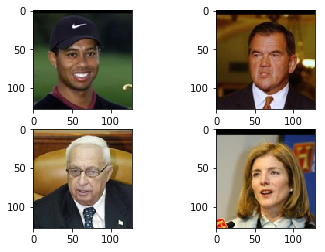

In [7]:
plt.figure(1)
plt.subplot(221)
plt.imshow(X_train[13, :, :, :])

plt.subplot(222)
plt.imshow(X_train[690, :, :, :])

plt.subplot(223)
plt.imshow(X_train[2375, :, :, :])

plt.subplot(224)
plt.imshow(X_train[4200, :, :, :])
plt.show()

**MODEL CONSTRUCTION**
We now construct the model for VAE  
The VAE has 3 major components:  
1) Encoder Model: Learns the destribution (mean and variance) of the data  
2) Sampling Function: Which samples from the learned distribution  
3) Decoder Model: Converts the sample chosen in #2 back to the image  
  
Both the Encoder model and Decoder model will be a Conv. Neural Net.  
For Encoder Model, notice that the last layer is split into two output layers, one for the latent distribution mean (z_mu) and the other for its variance (z_log_sigma).

In [8]:
# construct a custom layer to calculate the loss
class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        # Reconstruction loss
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        # KL divergence
        # kl_loss = -5e-4 * K.mean(1 + z_log_sigma - K.square(z_mu) - K.exp(z_log_sigma), axis=-1)
        kl_loss = -0.5 * K.mean(1 + 2*z_log_sigma - K.square(z_mu) - K.exp(2*z_log_sigma), axis=-1)
        return K.mean(xent_loss + kl_loss)

    # adds the custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

def sampling(args):
    z_mu, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mu)[0], LATENT_DIM),mean=0., stddev=1.)
    # print(K.int_shape(epsilon))
    return z_mu + K.exp(z_log_sigma) * epsilon


# ENCODER
input_img = keras.Input(shape=INPUT_SHAPE)

# layer1
x = layers.Conv2D(32, 3,
          padding='same', 
          activation='relu')(input_img)
# layer2
x = layers.Conv2D(64, 3,
          padding='same', 
          activation='relu',
          strides=(2, 2))(x)
# layer3
x = layers.Conv2D(64, 3,
          padding='same', 
          activation='relu')(x)
# layer4
# x = layers.Conv2D(256, 3,
#           padding='same', 
#           activation='relu')(x)

# need to know the shape of the network here for the decoder
shape_before_flattening = K.int_shape(x)
print("Encoder shape before flattening: ", shape_before_flattening)

# layer5
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

# layer6
z_mu = layers.Dense(LATENT_DIM)(x)
z_log_sigma = layers.Dense(LATENT_DIM)(x)

encoder = Model(input_img, z_mu)

# SAMPLING
# Sample from the latent distribution
z = layers.Lambda(sampling)([z_mu, z_log_sigma])
print("sampled latent space dimentions: ", K.int_shape(z))

# DECODER
# decoder takes the latent distribution sample as input
decoder_input = layers.Input(K.int_shape(z)[1:])

x = layers.Dense(32, activation='relu')(decoder_input)

# print(np.prod(shape_before_flattening[1:]))
x = layers.Dense(np.prod(shape_before_flattening[1:]),
             activation='relu')(x)

# reshape
x = layers.Reshape(shape_before_flattening[1:])(x)
print("Decoder 2D layer 1 dimentions: ", K.int_shape(x))

# use Conv2DTranspose to reverse the conv layers from the encoder
x = layers.Conv2DTranspose(64, 3,
                           padding='same', 
                           activation='relu')(x)
print("Decoder 2D layer 2 dimentions: ", K.int_shape(x))


x = layers.Conv2DTranspose(32, 3,
                           padding='same', 
                           activation='relu',
                           strides=(2, 2))(x)

print("sampled latent space dimentions: ", K.int_shape(x))

x = layers.Conv2D(3, 3,
                  padding='same', 
                  activation='sigmoid')(x)

# decoder model statement: This is done because decoder will be used seperately to generate images
decoder = Model(decoder_input, x)

# apply the decoder to the sample from the latent distribution
# decoder takes z as input
z_decoded = decoder(z)

# apply the custom loss to the input images and the decoded latent distribution sample
# Loss function is added as a layer. Thus  Y is the complete training model starting from
# imput_img -> encoder -> sampling -> decoder -> loss minimize
y = CustomVariationalLayer()([input_img, z_decoded])

# Make a complete model
vae = Model(input_img, y)
vae.compile(optimizer=OPTIMIZER, loss=None)
vae.summary()

Encoder shape before flattening:  (None, 64, 64, 64)
sampled latent space dimentions:  (None, 32)
Decoder 2D layer 1 dimentions:  (None, 64, 64, 64)
Decoder 2D layer 2 dimentions:  (None, 64, 64, 64)
sampled latent space dimentions:  (None, 128, 128, 32)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 64)   18496       conv2d_1[0][0]                   
____________________________________________________

In [9]:
vae.load_weights('vae_weights.h5')
vae.fit(x=X_train, y=None,
        shuffle=True,
        epochs=15,  # EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(X_val, None))


Train on 10586 samples, validate on 2647 samples
Epoch 1/15
10586/10586 [==============================] - 78s 7ms/step - loss: 1.3271 - val_loss: 0.7839
Epoch 2/15
10586/10586 [==============================] - 68s 6ms/step - loss: 0.6934 - val_loss: 0.6573
Epoch 3/15
10586/10586 [==============================] - 68s 6ms/step - loss: 0.6556 - val_loss: 0.6523
Epoch 4/15
10586/10586 [==============================] - 68s 6ms/step - loss: 0.6536 - val_loss: 0.6515
Epoch 5/15
10586/10586 [==============================] - 68s 6ms/step - loss: 0.6521 - val_loss: 0.6492
Epoch 6/15
10586/10586 [==============================] - 69s 7ms/step - loss: 0.6507 - val_loss: 0.6489
Epoch 7/15
10586/10586 [==============================] - 70s 7ms/step - loss: 0.6502 - val_loss: 0.6488
Epoch 8/15
10586/10586 [==============================] - 71s 7ms/step - loss: 0.6501 - val_loss: 0.6485- ET - ETA: 0s - loss: 0.6
Epoch 9/15
10586/10586 [==============================] - 72s 7ms/step - loss: 0.6497

In [10]:
# SAVE WEIGHTS
encoder.save_weights('vae_encoder.h5')
decoder.save_weights('vae_decoder.h5')
vae.save_weights('vae_weights.h5')

Generate Samples

In [ ]:
## Display a 2D manifold of the faces
import random
n = 5  # figure with 20x20 faces
face_size = 128
figure = np.zeros((face_size * n, face_size * n, 3))

# Construct grid of latent variable values
latent_factors = []
for i in range(LATENT_DIM):
    a = random.random()
    b = random.random()
    smaller = min(a,b)
    greater = max(a,b)
    print(smaller, greater)
    latent_factors.append(norm.ppf(np.linspace(smaller, greater, n*n)))
    # random.shuffle(latent_factors[-1])
latent_factors = np.array(latent_factors)
np.random.shuffle(latent_factors)

# print(latent_factors)
# grid_x = norm.ppf(np.linspace(0.01, 0.99, n))
# grid_y = norm.ppf(np.linspace(0.01, 0.99, n))
# print(grid_x)

# decode for each square in the grid
# for i, yi in enumerate(grid_x):
#     for j, xi in enumerate(grid_y):
#         z_sample = np.array([[xi, yi]])
#         z_sample = np.tile(z_sample, BATCH_SIZE).reshape(BATCH_SIZE, 2)
#         x_decoded = decoder.predict(z_sample, batch_size=BATCH_SIZE)
#         face = x_decoded[0].reshape(face_size, face_size, 3)
#         figure[i * face_size: (i + 1) * face_size,
#                j * face_size: (j + 1) * face_size, :] = face

for i in range(n):
    for j in range(n):
        idx = i*n+j
        z_sample = latent_factors[:, idx]
        # print(z_sample)
        z_sample = np.tile(z_sample, BATCH_SIZE).reshape(BATCH_SIZE, LATENT_DIM)
        # print(z_sample)
        x_decoded = decoder.predict(z_sample, batch_size=BATCH_SIZE)
        face = x_decoded[0].reshape(face_size, face_size, 3)
        figure[i * face_size: (i + 1) * face_size, j * face_size: (j + 1) * face_size, :] = face
        
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='gnuplot2')
plt.show()  

0.2932766044890939 0.681755227407612
0.4052085836841378 0.7925873745683878
0.11032410856350461 0.21435821086361273
0.22926377273925103 0.31635025810572204
0.0794155841921117 0.5395955562483621
0.8027092292561878 0.8678437112404908
0.8749149532175802 0.8901515383785897
0.47465377461303326 0.7106851796410121
0.26431310712586065 0.9689599326655105
0.19699736677004753 0.4629695187504079
0.5683572487823133 0.9771661410908453
0.48928901693495264 0.7312199385810766
0.5833032938615703 0.6215204024323269
0.0315986246405594 0.18045238575412859
0.09324642955023255 0.9866184410585355
0.01862565520655246 0.8026414002256953
0.38255550350011336 0.39957452101248814
0.1648675573939956 0.41005413390933854
0.17345613970566442 0.5416384243445933
0.0004705415787381595 0.9457634541332298
0.8254266691514441 0.8734300910803483
0.16141816977275614 0.18155254783123365
0.6535313065204663 0.7308704304760962
0.408864081839454 0.4542264801867021
0.6836293619299497 0.8888488203652277
0.6786929556208815 0.74235077689